# Aprendizaje supervisado

## Librerias y datos

In [1]:
import pandas as pd
import numpy as np
import io
import warnings
import matplotlib.pyplot as plt
import datetime
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('data.csv')
#Vars selected
vars_s=['arrival_month','deposit_type_Non Refund','is_repeated_guest','reserverd/assigned','hotel_Resort Hotel']

Y = data.is_canceled
X = data[vars_s]

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=1)
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (6700, 5) (6700,)
Test (3300, 5) (3300,)


## Regresion Logística

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
    
def evaluate_model(X_train, y_train,X_test, y_test, model):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="accuracy")
    diff = scores.mean() - model.score(X_test, y_test)
    SD = diff / scores.std()
    
    print(f"Training Score:{model.score(X_train, y_train)}")
    print(f"Cross V Score: {scores.mean()} +/- {scores.std()}")
    print(f"Testing Score: {model.score(X_test, y_test)}")
    print(f"Cross & Test Diff: {diff}")
    print(f"Standard Deviations Away: {SD}")
    print(confusion_matrix(y_test, preds))
   
    print(classification_report(y_test, preds))
    
    logit_roc_auc = roc_auc_score(y_test, preds)
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

### Balanceado

In [17]:
from imblearn.over_sampling import SMOTE

os = SMOTE(random_state=0)

os_data_X,os_data_y=os.fit_sample(X_train, y_train)

Training Score:0.6582519647535128
Cross V Score: 0.6582505231460215 +/- 0.009194504102821542
Testing Score: 0.7372727272727273
Cross & Test Diff: -0.0790222041267058
Standard Deviations Away: -8.594504199792139
[[2050    0]
 [ 867  383]]
              precision    recall  f1-score   support

           0       0.70      1.00      0.83      2050
           1       1.00      0.31      0.47      1250

    accuracy                           0.74      3300
   macro avg       0.85      0.65      0.65      3300
weighted avg       0.82      0.74      0.69      3300



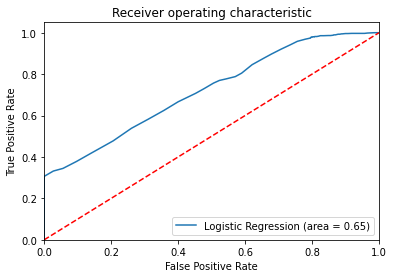

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

reg_log = LogisticRegression(random_state=0, solver='newton-cg', max_iter=1000)
evaluate_model(os_data_X, os_data_y, X_test, y_test, reg_log)